In [2]:
import sys
import torch

sys.path.append('../src')

from bearing_dataset import BearingDataset, Normalize
from catgan import Classifier, Generator

In [3]:
bearing_dataset = BearingDataset(type='A')
print('Loaded bearing dataset type ', bearing_dataset.get_type(), ' with ',
      bearing_dataset.get_cats_num(), ' categories, total ', len(bearing_dataset), ' samples ')


Loaded bearing dataset type  A  with  4  categories, total  3776  samples 


In [4]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

generator = Generator().to(device)
classifier = Classifier(cat_num = bearing_dataset.get_cats_num()).to(device)


In [5]:
optimizators = {
    'G': torch.optim.Adam(generator.parameters(), lr=0.001),
    'C': torch.optim.Adam(classifier.parameters(), lr=0.0001),   
}

losses = {
    'C': [],
    'G': []
}

In [6]:
from torch.utils.data import DataLoader

train_set, val_set = torch.utils.data.random_split(bearing_dataset, [len(bearing_dataset)*7//10, len(bearing_dataset)-len(bearing_dataset)*7//10])

K = bearing_dataset.get_cats_num()
N = 10
M = N*K

train_loader = DataLoader(train_set, batch_size=M, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, drop_last=True)
len(train_loader), len(val_loader)

softmax = torch.nn.Softmax(dim=1)


In [7]:
## Supervised classifier training
from tqdm.notebook import tqdm

supervised_classifier = Classifier(cat_num = bearing_dataset.get_cats_num()).to(device)

supervised_optim = torch.optim.Adam(supervised_classifier.parameters(), lr=0.0001)

supervised_criterion = torch.nn.CrossEntropyLoss().to(device)

supervised_losses = []
supervised_classifier.train()

for epoch in range(100):
    for image, labelidx in tqdm(train_loader, desc = 'train loop', leave = True, disable = True):
        image = torch.unsqueeze(image,1).float()
        supervised_optim.zero_grad()
        image = image.to(device)
        out = supervised_classifier(image)
        target = torch.zeros(len(labelidx),bearing_dataset.get_cats_num())
        for idx, tv in enumerate(target):
            tv[labelidx[idx]]=1.
        supervised_loss = supervised_criterion(out, target.to(device))
        supervised_loss.backward()
        supervised_optim.step()
        supervised_losses.append(supervised_loss.item())

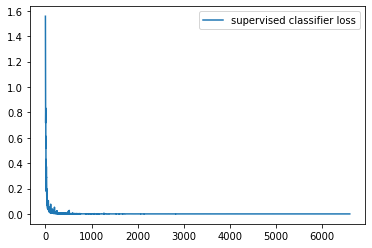

In [8]:
import matplotlib.pyplot as plt

plt.plot(supervised_losses, label='supervised classifier loss')
plt.legend()
plt.show()

In [13]:
## Supervised learning generator

from tqdm.notebook import tqdm
from torch.distributions import Categorical

supervised_classifier.eval()

supervised_generator =  Generator().to(device)

supervised_gen_optim = torch.optim.Adam(supervised_generator.parameters(), lr=0.0001)

supervised_gen_criterion = torch.nn.CrossEntropyLoss().to(device)

supervised_glosses = []
supervised_generator.train()
for epoch in range(35):
    for images, labels in tqdm(train_loader, position=0, leave=False):

        # train G
        optimizators['G'].zero_grad()

        noise = torch.randn(M,200,1,1).to(device)      
        fake = supervised_generator(noise)
        fake = (fake+1)/2
#         for fidx in range(fake.shape[0]):
#             fake[fidx] = Normalize(fake[fidx])
        out_fake = supervised_classifier(fake)

        
        E_G = 0;
        for fidx in range(out_fake.shape[0]):
            E_G += Categorical(probs = softmax(out_fake)[fidx]).entropy()
        E_G /= M;
      
        H_G = Categorical(probs = torch.mean(softmax(out_fake),dim=0)).entropy()
        
        loss_sg = abs( -H_G + E_G)
#        loss_g = E_G

        loss_sg.backward()
#        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)

        supervised_gen_optim.step()
        
        supervised_glosses.append(loss_sg.item())
    print('epoch #', epoch)
    print(loss_g.item())

  0%|          | 0/66 [00:00<?, ?it/s]

epoch # 0


NameError: name 'loss_g' is not defined

In [9]:
plt.plot(supervised_glosses, label='supervised generator loss')
plt.legend()
plt.show()

NameError: name 'supervised_glosses' is not defined

In [14]:
## Unsupervised learning

from tqdm.notebook import tqdm
from torch.distributions import Categorical

for epoch in range(35):
    for images, labels in tqdm(train_loader, position=0, leave=False):
        noise = torch.randn(M,200,1,1).to(device)
        images = images.float().to(device)
        images = torch.unsqueeze(images,1)
       
        # train C
        optimizators['C'].zero_grad()

        fake = generator(noise)
        fake = (fake+1)/2
        
        # generate fake images
#         for fidx in range(fake.shape[0]):
#             fake[fidx] = (fake[fidx]-fake[fidx].min())/(fake[fidx].max()-fake[fidx].min())
        
        
        out_real = classifier(images)
        out_fake = classifier(fake)
        
        H_X = Categorical(probs = torch.mean(softmax(out_real),dim=0)).entropy()
        
        E_X = 0;
        for ridx in range(out_real.shape[0]):
            E_X += Categorical(probs = softmax(out_real)[ridx]).entropy()
        E_X /= M;

        E_G = 0;
        for fidx in range(out_fake.shape[0]):
            E_G += Categorical(probs = softmax(out_fake)[fidx]).entropy()
        E_G /= M;
      
        H_G = Categorical(probs = torch.mean(softmax(out_fake),dim=0)).entropy()
        
        loss_c = abs( H_X - E_X + E_G)
        loss_c.backward()
#        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1)
        optimizators['C'].step()

        losses['C'].append(loss_c.item())
        # don't forget to use item
        
        # train G
        optimizators['G'].zero_grad()

        noise = torch.randn(M,200,1,1).to(device)      
        fake = generator(noise)
        fake = (fake+1)/2
#         for fidx in range(fake.shape[0]):
#             fake[fidx] = Normalize(fake[fidx])
        classifier.eval()
        out_fake = classifier(fake)
        classifier.train()
        
        E_G = 0;
        for fidx in range(out_fake.shape[0]):
            E_G += Categorical(probs = softmax(out_fake)[fidx]).entropy()
        E_G /= M;
      
        H_G = Categorical(probs = torch.mean(softmax(out_fake),dim=0)).entropy()
        
        loss_g = abs( -H_G + E_G)
#        loss_g = E_G

        loss_g.backward()
#        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)

        optimizators['G'].step()
        
        losses['G'].append(loss_g.item())
    print('epoch #', epoch)
    print(loss_g.item())
    

  0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# torch.save(generator.state_dict(),'generator.weights')
# torch.save(classifier.state_dict(),'classifier.weights')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses['G'][1000:], label='generator loss')
plt.legend()
plt.show()

plt.plot(losses['C'], label='classifier loss')
plt.legend()
plt.show()

In [ ]:
generator.load_state_dict(torch.load('generator.weights', map_location=device))
classifier.load_state_dict(torch.load('classifier.weights', map_location=device))

In [ ]:
orig = bearing_dataset.getimgs(3)[12]
plt.imshow(orig)
print (orig.shape)
orig = torch.unsqueeze(torch.from_numpy(orig),0)
orig = torch.unsqueeze(orig,0).float()
print (orig.shape)
out = classifier(orig.to(device))
print(softmax(out))
out = supervised_classifier(orig.to(device))
print(softmax(out))


In [ ]:
supervised_classifier.eval()
classifier.eval()

with torch.no_grad():
    r=0
    while r<0.9999:
        noise = torch.randn(1,200,1,1)
        emb = generator(noise.to(device))
        for fidx in range(emb.shape[0]):
            emb[fidx] = Normalize(emb[fidx])
        emb = Normalize(emb)
        out = supervised_classifier(emb)
        if softmax(out).max() > r:
            r = softmax(out).max()
            print(r)
            
        

    plt.imshow(emb.cpu().squeeze(0).squeeze(0).detach().numpy())
    print('unsupervised out:', softmax(out))

    supervised_out =  classifier(emb)
    print('supervised out:', softmax(supervised_out))

plt.imshow(orig.squeeze())


In [ ]:
supervised_classifier.eval()
classifier.eval()

with torch.no_grad():
    r=0
    while r<0.9999:
        noise = torch.randn(1,200,1,1)
        emb = generator(noise.to(device))
        for fidx in range(emb.shape[0]):
            emb[fidx] = Normalize(emb[fidx])
        emb = Normalize(emb)
        out = supervised_classifier(emb)
        if softmax(out).max() > r:
            r = softmax(out).max()
            print(r)
            
        

    plt.imshow(emb.cpu().squeeze(0).squeeze(0).detach().numpy())
    print('supervised out:', softmax(out))

    print(emb.shape)
    supervised_out =  classifier(emb)
    print('unsupervised out:', softmax(supervised_out))

    plt.imshow(emb.cpu().squeeze(0).squeeze(0).detach().numpy())


  0%|          | 0/1133 [00:00<?, ?it/s]

/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Bearing data T-SNE projection unsupervised')]

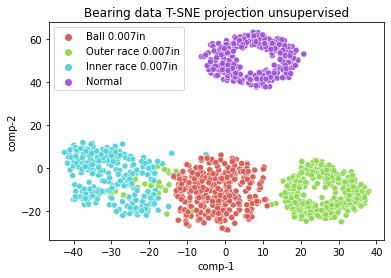

In [19]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE()
classifier.eval()
latent = []
target = []
labels = ['Normal', 'Ball 0.007in','Inner race 0.007in','Outer race 0.007in']
for x, y in tqdm(val_loader):
    x = torch.unsqueeze(x,1).float()
    latent.append(classifier.get_latent_features(x.to(device)).detach().to('cpu'))
    target.append(labels[y[0]])
latent = torch.cat(latent, dim=0).numpy()
tsne_latent = tsne.fit_transform(latent)
# plt.scatter(tsne_latent[:, 0], tsne_latent[:, 1])
# plt.show()

df = pd.DataFrame()
df["y"] = target
df["comp-1"] = tsne_latent[:,0]
df["comp-2"] = tsne_latent[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Bearing data T-SNE projection unsupervised") 

  0%|          | 0/1133 [00:00<?, ?it/s]

/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Bearing data T-SNE projection supervised')]

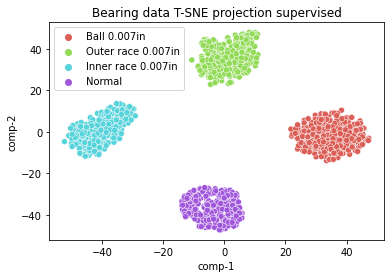

In [20]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE()
supervised_classifier.eval()
latent = []
target = []
labels = ['Normal', 'Ball 0.007in','Inner race 0.007in','Outer race 0.007in']
for x, y in tqdm(val_loader):
    x = torch.unsqueeze(x,1).float()
    latent.append(supervised_classifier.get_latent_features(x.to(device)).detach().to('cpu'))
    target.append(labels[y[0]])
latent = torch.cat(latent, dim=0).numpy()
tsne_latent = tsne.fit_transform(latent)
# plt.scatter(tsne_latent[:, 0], tsne_latent[:, 1])
# plt.show()

df = pd.DataFrame()
df["y"] = target
df["comp-1"] = tsne_latent[:,0]
df["comp-2"] = tsne_latent[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Bearing data T-SNE projection supervised") 

In [92]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE()
classifier.eval()
clss = []
target = []
both = []
for x, y in tqdm(val_loader):
    x = torch.unsqueeze(x,1).float()
    cls = classifier(x.to(device))
    print(softmax(cls))
    
    clss.append(cls)
    target.append(float(y[0]))
    both.append((torch.argmax(cls),int(y[0])))


  0%|          | 0/1133 [00:00<?, ?it/s]

tensor([[1.3594e-05, 1.6802e-03, 9.9827e-01, 3.5913e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.9846e-08, 9.9204e-07, 1.0000e+00, 9.7287e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.3477e-04, 2.8020e-02, 9.7115e-01, 5.9072e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.9646e-07, 6.6779e-06, 9.9999e-01, 1.1151e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[5.2237e-05, 5.3964e-03, 9.9443e-01, 1.1854e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[7.6421e-07, 1.1692e-05, 9.9999e-01, 1.7513e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.7751e-05, 2.2318e-03, 9.9768e-01, 6.4810e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.9062e-05, 2.3885e-03, 9.9756e-01, 2.9403e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[8.6397e-05, 1.1863e-01, 8.8119e-01, 9.5558e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[5.3528e-05, 7.2904e-02, 9.2698e-01, 5.8097e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[9.3714e-07, 1.5856e-05, 9.9998e-01, 2.9087e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.2125e-04, 1.2143e-02, 9.8742e-01, 3.1771e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.3351e-05, 5.7469e-04, 9.9938e-01, 3.0102e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.1387e-04, 1.6050e-02, 9.8334e-01, 4.0030e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.6176e-07, 1.6681e-05, 9.9998e-01, 1.2903e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[9.1916e-06, 6.5395e-04, 9.9932e-01, 1.8623e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[8.8301e-08, 1.4904e-06, 1.0000e+00, 1.5551e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.6790e-05, 2.0872e-03, 9.9777e-01, 1.0936e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[1.5314e-07, 3.7545e-06, 1.0000e+00, 5.5801e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.1899e-07, 4.1054e-06, 1.0000e+00, 2.8755e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.2291e-04, 1.5297e-01, 8.4679e-01, 1.2044e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.7097e-06, 2.4717e-04, 9.9974e-01, 9.5509e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.0701e-09, 3.9167e-08, 1.0000e+00, 1.6844e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.9676e-08, 4.1547e-07, 1.0000e+00, 1.8996e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.6663e-05, 2.1074e-02, 9.7888e-01, 1.9708e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.1701e-05, 1.5345e-03, 9.9836e-01, 7.5737e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.9281e-06, 2.2971e-04, 9.9975e-01, 1.7258e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[5.3423e-05, 4.8590e-02, 9.5131e-01, 4.7264e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.1333e-06, 7.1846e-05, 9.9992e-01, 3.2922e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[5.4158e-07, 2.1098e-05, 9.9998e-01, 1.4880e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.1054e-04, 1.4849e-01, 8.5129e-01, 1.0841e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[9.2748e-08, 3.3588e-06, 1.0000e+00, 3.1216e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.6111e-05, 6.9445e-02, 9.3043e-01, 5.7387e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.0364e-07, 7.5244e-06, 9.9999e-01, 8.5463e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.3499e-04, 9.5033e-02, 9.0473e-01, 1.0533e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.6095e-06, 1.0624e-04, 9.9988e-01, 1.0681e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[1.0824e-05, 1.1430e-03, 9.9882e-01, 3.0699e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.2916e-09, 4.1853e-08, 1.0000e+00, 4.8000e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.5977e-07, 9.0148e-06, 9.9999e-01, 7.5541e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.6119e-05, 3.1343e-04, 9.9962e-01, 5.2089e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.7402e-07, 3.5009e-06, 1.0000e+00, 4.9054e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.6474e-05, 2.1109e-03, 9.9783e-01, 4.1827e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.9849e-04, 8.0308e-02, 9.1753e-01, 1.4601e-03]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.6592e-06, 3.4949e-04, 9.9964e-01, 9.8193e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.2036e-05, 2.2574e-03, 9.9765e-01, 6.4616e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[7.5734e-05, 8.9000e-03, 9.9086e-01, 1.6482e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.0194e-06, 2.3027e-05, 9.9997e-01, 2.3258e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.9314e-05, 3.8573e-02, 9.6134e-01, 3.6176e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.4958e-06, 3.0577e-05, 9.9996e-01, 2.8926e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.0829e-07, 3.9547e-06, 1.0000e+00, 3.1448e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.9558e-06, 2.2938e-04, 9.9975e-01, 1.2005e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.0295e-04, 1.1865e-01, 8.8115e-01, 9.2664e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.7388e-04, 2.2938e-01, 7.7028e-01, 1.7298e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.2536e-08, 2.4849e-07, 1.0000e+00, 9.8013e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[2.3968e-04, 1.4204e-02, 9.8516e-01, 3.9167e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[9.7513e-08, 1.9586e-06, 1.0000e+00, 1.9759e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[7.0779e-05, 9.0256e-02, 9.0960e-01, 7.3136e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.3708e-06, 6.4575e-05, 9.9993e-01, 3.9812e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.4446e-07, 5.8592e-06, 9.9999e-01, 4.1303e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.1255e-04, 9.2449e-02, 9.0734e-01, 1.0234e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.6203e-05, 2.6723e-03, 9.9721e-01, 8.3884e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.8268e-07, 2.6090e-05, 9.9997e-01, 2.3923e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.8675e-06, 3.0067e-05, 9.9996e-01, 5.9825e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[7.2282e-07, 7.9420e-06, 9.9999e-01, 9.8300e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.7253e-06, 3.0759e-04, 9.9967e-01, 1.1790e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.8351e-06, 1.9240e-04, 9.9980e-01, 8.8443e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.0439e-05, 2.8477e-02, 9.7145e-01, 2.7842e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[4.1851e-07, 4.4241e-05, 9.9995e-01, 9.5609e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.3213e-05, 8.2429e-02, 9.1745e-01, 6.0994e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[2.0201e-05, 1.1011e-03, 9.9883e-01, 5.1860e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.7516e-04, 2.0776e-01, 7.9191e-01, 1.5966e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.0880e-06, 4.2083e-05, 9.9995e-01, 3.3222e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t

tensor([[5.9871e-05, 2.5070e-03, 9.9731e-01, 1.2190e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.1768e-07, 2.0154e-05, 9.9998e-01, 1.0934e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[7.4016e-05, 7.6302e-02, 9.2357e-01, 5.5853e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.2841e-05, 5.1957e-03, 9.9459e-01, 1.5582e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.7621e-05, 3.9610e-02, 9.6032e-01, 3.3400e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.4459e-08, 2.3567e-06, 1.0000e+00, 1.6881e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[6.4451e-05, 7.7772e-02, 9.2211e-01, 5.6434e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[1.4902e-07, 3.4430e-06, 1.0000e+00, 4.2581e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[3.2326e-07, 1.1624e-05, 9.9999e-01, 1.1759e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
t